<a href="https://colab.research.google.com/github/RehamJamal13/model/blob/main/netork_of_CoAuthorWithWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Download pakages
#NATURAL LANGUAGE PROCESSING
!pip install pandas
!pip install networkx
!pip install matplotlib
! pip install pyvis
!pip install nameparser

In [ ]:
#@title Load Packages
#!pip install nameparser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
#from Topic_Modeling import *
#import scispacy
#import spacy
#import en_core_sci_lg
import networkx as nx
from pathlib import Path
from itertools import combinations
from collections import Counter
from itertools import chain
import random
from pyvis.network import Network
from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations
from gensim.models.word2vec import Word2Vec
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from sklearn.cluster import KMeans

In [ ]:
#@title Load Data
data= pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Copy of Copy_of_Author_paper.csv')

##CoAuthor Network

In [ ]:
#data = data.drop(columns=['Author_split'])
data['Author_split']=data['Author'].apply(lambda x: x.replace("'", "").strip('][').split(', '))



In [ ]:
data['Author_pairs']=data['Author_split'].apply(lambda x:list(combinations(x, 2)))
data.head()

,DOC_ID,Author,Author_split,Author_pairs
0,0,['Unknown author'],[Unknown author],[]
1,2,['Unknown author'],[Unknown author],[]
2,3,['Unknown author'],[Unknown author],[]
3,4,['Unknown author'],[Unknown author],[]
4,5,['Unknown author'],[Unknown author],[]


In [ ]:
data['Author_split'][386]

['abdel gadir', ' m. a. mahadi', ' s. e. nasr', ' a. o. ahmed', ' m. e.']

In [ ]:
def flattenList(nested_list):
    flat_list = [item for sublist in nested_list for item in sublist]
    return flat_list

In [ ]:
ai_authors=pd.DataFrame(flattenList(data['Author_split'].tolist())).rename(columns={0:'Author_split'})
papers_by_authors=ai_authors.groupby(['Author_split']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False)
papers_by_authors.shape

(35480, 2)

In [ ]:
papers_by_authors['Number of Papers Published'].describe()

count    35480.000000
mean         1.687796
std          6.647992
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        495.000000
Name: Number of Papers Published, dtype: float64

In [ ]:
## Keeping Authors who have published more than 2 Papers
nodes_to_keep=papers_by_authors.loc[papers_by_authors['Number of Papers Published']>2,'Author_split'].tolist()
len(nodes_to_keep)

2462

#Generating the Edges of the Co-Author Network

In [ ]:
authors_pairs=data['Author_pairs'].tolist()
authors_edge_list=[item for sublist in authors_pairs for item in sublist]
authors_weighted_edge_list=list(Counter(authors_edge_list).items())
authors_weighted_edge_list=[(row[0][0],row[0][1],row[1]) for idx,row in enumerate(authors_weighted_edge_list)]
authors_weighted_edge_list[0:10]

[('-elgayoum', ' salwa. m. e. el-feki', 1),
 ('-elgayoum', ' abd el-karim ahmed. mahgoub', 1),
 ('-elgayoum', ' babiker ahmed. el-rayah', 1),
 ('-elgayoum', ' elamin. giha', 1),
 ('-elgayoum', ' hayder.  a.', 1),
 (' salwa. m. e. el-feki', ' abd el-karim ahmed. mahgoub', 1),
 (' salwa. m. e. el-feki', ' babiker ahmed. el-rayah', 1),
 (' salwa. m. e. el-feki', ' elamin. giha', 1),
 (' salwa. m. e. el-feki', ' hayder.  a.', 1),
 (' abd el-karim ahmed. mahgoub', ' babiker ahmed. el-rayah', 1)]

In [ ]:
G1=nx.Graph()
G1.add_weighted_edges_from(authors_weighted_edge_list)
print(len(G1.nodes()))

35439


In [ ]:
## From the complete Graph, create a subgraph, with only the nodes to keep
#Keeping Authors who have published at least 3 papers
sub_g=nx.subgraph(G1,nodes_to_keep)
G=nx.Graph(sub_g)
print(len(G.nodes()))
isolated_node=nx.isolates(G)
len(list(isolated_node))

2460


35

In [ ]:
G.remove_nodes_from(list(nx.isolates(G)))
len(G.nodes)

2425

In [ ]:
del G1, sub_g
print("Number of Nodes in Author Graph ",len(G.nodes()))
print("Number of Edges in AUthor Graph ",len(G.edges()))

Number of Nodes in Author Graph  2425
Number of Edges in AUthor Graph  10121


#Implementing Deep Walk

In [ ]:
def getRandomWalk(graph,node,length_of_random_walk):
    """ This function takes NetworkX Graph and a Node and generate random walk for a given length

    Returns the random walk (list of nodes traversed)

    Note: The same node may occcur more than once in a Random Walk.
    """
    start_node=node
    current_node=start_node
    random_walk=[node]
    for i in range(0,length_of_random_walk):
        ## Choose a random neighbour of the current node

        current_node_neighbours=list(graph.neighbors(current_node))
        chosen_node=random.choice(current_node_neighbours)
        current_node=chosen_node
        random_walk.append(current_node)
    return random_walk

In [ ]:

### For every Node in the Graph, get randomwalks . For eahc node, let us get random walks say around 10 times each of path length 10
num_sampling=10
random_walks=[]
length_of_random_walk=10
for node in tqdm(G.nodes(),desc="Iterating Nodes"):

    for i in range(0,num_sampling):
        random_walks.append(getRandomWalk(G,node,length_of_random_walk))


Iterating Nodes:   0%|          | 0/2425 [00:00<?, ?it/s]

In [ ]:
deepwalk_model=Word2Vec(sentences=random_walks,window=5,sg=1,negative=5,vector_size=128,epochs=20,compute_loss=True)

In [ ]:
deepwalk_model.save("deepwalk_biblography.model")

#Lets Look who are similar authors

In [ ]:
def getSimilarNodes(model,node):
    """
    This function takes deepwalk model and a node

    Returns the top 10 nodes (author) similar to the given node
    """
    similarity=model.wv.most_similar(node)
    similar_nodes=pd.DataFrame()
    similar_nodes['Similar_Node']=[row[0] for i,row in enumerate(similarity)]
    similar_nodes['Similarity_Score']=[row[1] for i,row in enumerate(similarity)]
    similar_nodes['Source_Node']=node
    return similar_nodes

In [ ]:
getSimilarNodes(deepwalk_model,"ali")

,Similar_Node,Similarity_Score,Source_Node
0,intisar waly,0.672151,ali
1,b. h. bartlet,0.670361,ali
2,mohamed nemmar,0.661679,ali
3,nicole,0.657301,ali
4,a. l.,0.655171,ali
5,rb,0.647909,ali
6,isehaq beegam,0.647139,ali
7,b. h. al-salam,0.645683,ali
8,mostafa i. yasin,0.621261,ali
9,javed fahim,0.612499,ali


In [ ]:
ai_authors=pd.DataFrame(flattenList(data['Author_split'].tolist())).rename(columns={0:'Author_split'})
papers_by_authors=ai_authors.groupby(['Author_split']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False)
papers_by_authors

,Author_split,Number of Papers Published
8,a.,495
1804,a. m.,372
16882,m,337
30732,ali,294
24760,s.,257
...,...,...
15332,k. c. el-tigani,1
15331,k. c.,1
3791,amal a. a. rahbeeni,1
15329,k. bradley,1


In [ ]:
#Lets get the graph of these top Authors with their first step neighbours.We consider the authors ranked 4th to 10th to help visualise the clusters better
def getCoAuthorshipNetwork(graph,initial_nodes):
    """
    This function takes a Graph and list of initial nodes

    Returns the set of immediate neighbours of these nodes

    """
    total_neighbours=0
    nodes_set=[initial_nodes]
    for node in initial_nodes:
        #print(node)
        neighbours=list(graph.neighbors(node))
        total_neighbours=total_neighbours+len(neighbours)

        nodes_set.append(neighbours)
    print(total_neighbours)
    nodes_set=flattenList(nodes_set)
    return list(set(nodes_set))

In [ ]:
coauthor_nodes=getCoAuthorshipNetwork(G,papers_by_authors['Author_split'].tolist()[4:10])
print("Number of CoAuthor Nodes ",len(coauthor_nodes))

735
Number of CoAuthor Nodes  616


Generate a Co-Author Graph from the complete Graph

In [ ]:
coauthor_subgraph=nx.subgraph(G,coauthor_nodes)
print("number of edges in the CoAuthor Subgraph ",len(coauthor_subgraph.edges()))

number of edges in the CoAuthor Subgraph  2640


In [ ]:
nx.write_gexf(coauthor_subgraph, "CoAuthor_Subgraph_Author4to10.gexf")

In [ ]:
#coauthor_subgraph=nx.read_gexf("CoAuthor_Subgraph_Top50Author.gexf")
print("number of edges in the CoAuthor Subgraph ",len(coauthor_subgraph.edges()))

number of edges in the CoAuthor Subgraph  2640


In [ ]:
pyvis_nt=Network(notebook=True,height='800px', width='100%',heading='', cdn_resources='remote')#, cdn_resources='in_line')

print("Creating PyVis from NetworkX")
pyvis_nt.from_nx(coauthor_subgraph)

print("Saving PyVis Graph")
pyvis_nt.show("Author4to10_CoAuthorGraph.html")

Creating PyVis from NetworkX
Saving PyVis Graph
Author4to10_CoAuthorGraph.html


Cluster the Nodes

In [ ]:
def getCosineDistanceMatrix(vectors):
    '''
    This function takes list of vectors or numpy array

    Returns the pairwise cosine similarity matrix
    '''
    if type(vectors)==list:
        X=np.asarray(vectors)
    elif type(vectors)==np.ndarray:
        X=vectors
    else:
        print("Error in Data Type . Need to Pass list or numpy array as input argument")
        return []
    cosine_dist=cosine_distances(X)
    return cosine_dist

In [ ]:
coauthor_nodes=list(coauthor_subgraph.nodes)
print("Number of CoAuthor Subgraph Nodes",len(coauthor_nodes))

Number of CoAuthor Subgraph Nodes 616


In [ ]:
coauthor_embeddings=[deepwalk_model.wv[node] for node in coauthor_nodes]
coauthor_embeddings=np.asarray(coauthor_embeddings)
print(coauthor_embeddings.shape)
cosine_dist=getCosineDistanceMatrix(coauthor_embeddings)

(616, 128)


In [ ]:
#K-mean for optimal number of clusters
sse=[]
k_list=[]
for k in range(2,20):

    km=KMeans(n_clusters=k)
    km.fit(cosine_dist)
    sse.append(km.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

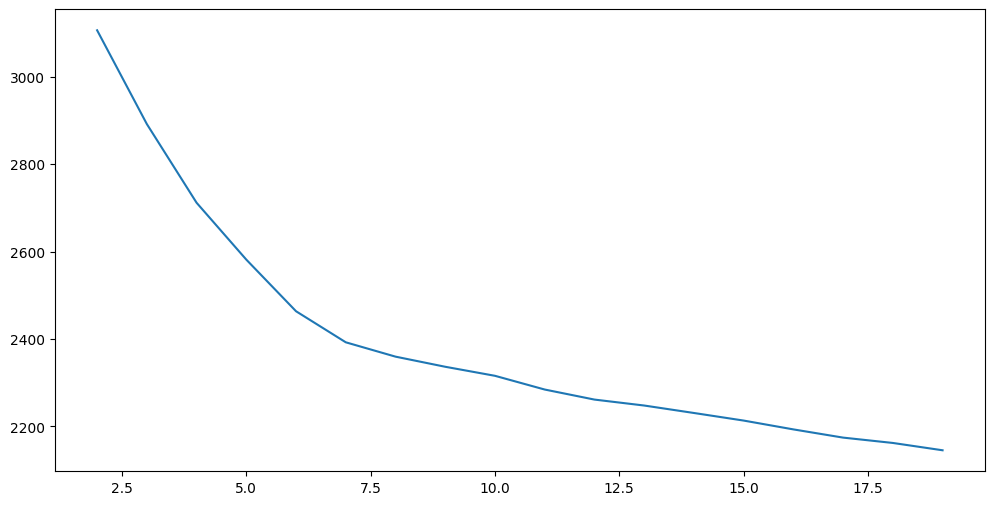

In [ ]:
plt.figure(figsize=(12,6))
plt.plot([i for i in range(2,20)],sse)

In [ ]:
#from figure lets picke 8 clusters
km=KMeans(n_clusters=8)
coauthor_clusters=km.fit_predict(cosine_dist)
coauthor_cluster_dict={node:str(coauthor_clusters[idx]) for idx,node in enumerate(coauthor_nodes)}
nx.set_node_attributes(coauthor_subgraph,coauthor_cluster_dict,"group")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
pyvis_nt=Network(notebook=True,height='600px', width='100%',heading='Author Network', cdn_resources='in_line')

print("Creating PyVis from NetworkX")
pyvis_nt.from_nx(coauthor_subgraph)
pyvis_nt.toggle_physics(True)
print("Saving PyVis Graph")
#pyvis_nt.show_buttons()
#pyvis_nt.set_options('var options = {"edges": { "color": { "inherit": true },"smooth": false},"physics": {"hierarchicalRepulsion": { "centralGravity": 0 },"minVelocity": 0.75, "solver": "hierarchicalRepulsion","timestep": 0.18}}')


pyvis_nt.show("Author4to10_CoAuthorGraph_Clustered.html")


Creating PyVis from NetworkX
Saving PyVis Graph
Author4to10_CoAuthorGraph_Clustered.html


Visualising El hassan Network

In [ ]:
el_hassan_nodes=getCoAuthorshipNetwork(G,['el hassan'])
el_hassan_network=nx.subgraph(G,el_hassan_nodes)
print("Number of Nodes in El hassan Network ",len(el_hassan_network.nodes()))
print("Number of Edges in El hassan Network ",len(el_hassan_network.edges()))

54
Number of Nodes in El hassan Network  55
Number of Edges in El hassan Network  195


In [ ]:
el_hassan_nt=Network(notebook=True,height='800px', width='100%',heading='El hassan Network', cdn_resources='in_line')

print("Creating PyVis from NetworkX")
el_hassan_nt.from_nx(el_hassan_network)
el_hassan_nt.toggle_physics(True)
#el_hassan_nt.enable_physics(True)
print("Saving PyVis Graph")

el_hassan_nt.show_buttons()
el_hassan_nt.show("El hassan_CoAuthorGraph.html")

Creating PyVis from NetworkX
Saving PyVis Graph
El hassan_CoAuthorGraph.html
